In [2]:
import os
import time
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats
from skimage.transform import resize
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
norm1 = ImageNormalize(stretch=LogStretch())
norm2 = ImageNormalize(stretch=LogStretch())
from utils import *

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})

In [3]:
pix_scale = 2.5
ZP = 27.1
seeing = 2.5
mu = 10

In [4]:
hdu = fits.open("./med_psf_JX.fits")[0]
PSF_JX = hdu.data * 10 + mu
PSF_JX0 = PSF_JX.copy()
print("Flux: ", PSF_JX.sum())
yy, xx = np.indices(PSF_JX.shape)
rr = np.sqrt((xx-50)**2+(yy-50)**2)
mask = ((abs(yy-50)<1.) | (abs(xx-50)<1.)) & (rr>10) | (rr>40)
PSF_JX[mask] = np.nan

Flux:  795417.8721842369


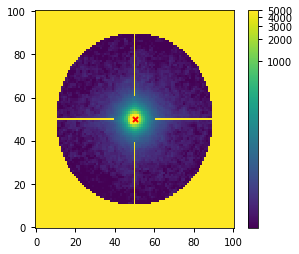

In [5]:
plt.figure(figsize=(4,4))
im = plt.imshow(PSF_JX, vmin=mu, vmax=5000, norm=norm1, aspect="auto", origin="lower", cmap="viridis")
plt.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

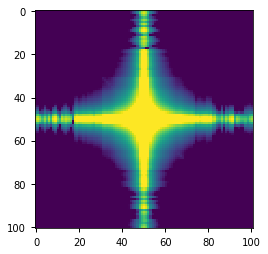

In [11]:
Cov_PSF = np.sqrt(np.cov(PSF_JX0)**2+np.cov(PSF_JX0)**2)
plt.imshow(Cov_PSF, norm=norm1)

/home/qliu/Desktop/PSF/utils.py:41: RuntimeWarning: divide by zero encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)
/home/qliu/Desktop/PSF/utils.py:41: RuntimeWarning: invalid value encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)


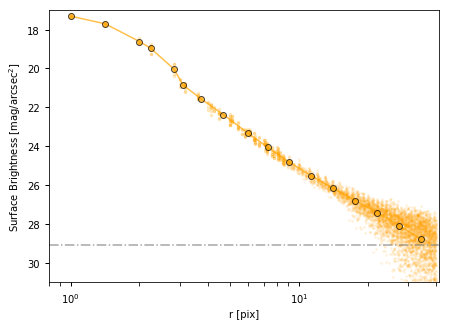

In [10]:
plt.figure(figsize=(7,5))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=mask,
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="orange",
                                             dr=0.3, scatter=True, core_undersample=True)

### Moffat: 

$f_{\rm Moffat} (r) = A \left [ 1 + \left ( \frac{r-r_0}{R} \right )^2 \right ]^{-\beta}$

$A = \frac{\Gamma(\beta)}{R\sqrt{\pi} \Gamma(\beta-\frac{1}{2})}$ 

${\rm FWHM} := 2(r_{1/2} - r_0) = 2 R \sqrt{2^{1/\beta}-1}$

core width: 4.26, power index: 10.00


/home/qliu/Desktop/PSF/utils.py:41: RuntimeWarning: divide by zero encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)
/home/qliu/Desktop/PSF/utils.py:41: RuntimeWarning: invalid value encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)


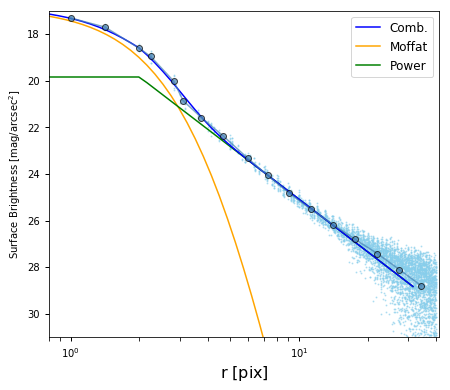

In [13]:
r = np.logspace(-2,1.5,100)

fwhm = 2.28
beta = 10.
gamma = fwhm/2./np.sqrt(2**(1./beta)-1)
print("core width: %.2f, power index: %.2f"%(gamma,beta))
n = 3
theta_t_pix = 2.
frac = 0.16

A = 4e5
F_mof = moffat1d_Amp2Flux(gamma, beta, Amp=A)
F_pow = F_mof * frac / (1-frac)
A_pow = power1d_Flux2Amp(n, theta_t_pix, Flux=F_pow)
C_mof2Dto1D =  1./(beta-1) * 2*math.sqrt(np.pi) * gamma * Gamma(beta) / Gamma(beta-1./2) 
C_pow2Dto1D = np.pi * theta_t_pix * (n-1) / (n-2)

moffat1d = models.Moffat1D(amplitude=A, x_0=0, gamma=gamma, alpha=beta)
comp1 = moffat1d(r) / C_mof2Dto1D
comp2 = trunc_power1d(r, n, theta_t_pix, I_theta0=A_pow) / C_pow2Dto1D


plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=mask, 
                                             ZP=ZP, sky_mean=mu, sky_std=1e-2, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="steelblue",
                                             dr=0.3, scatter=False, core_undersample=True)
plt.scatter(rr, Intensity2SB(PSF_JX, mu, ZP, pix_scale), color="skyblue", s=1, alpha=0.5)

plt.plot(r, Intensity2SB(comp1+comp2+mu, mu, ZP, pix_scale), ls="-",color="b",label="Comb.",zorder=2)
plt.plot(r, Intensity2SB(comp1+mu, mu, ZP, pix_scale), ls="-",color="orange",label="Moffat",zorder=1)
plt.plot(r, Intensity2SB(comp2+mu, mu, ZP, pix_scale), ls="-",color="g",label="Power",zorder=1)
plt.legend(fontsize=12)
plt.xlabel(r"r $\rm[pix]$",fontsize=16)
plt.xscale("log")

# # A_mof = moffat1d_Flux2Amp(gamma, beta, Flux=PSF_JX.sum()*0.5)
# I = moffat_power1d(r, gamma=2, alpha=3., n=3.5, theta0=4, A=1e5)
# plt.plot(r, np.log10(I+mu), ls="-",color="k",lw=2,zorder=2,alpha=0.8)

### Nested Fitting

In [14]:
d = stats.truncnorm(a=-1, b=2, loc=3, scale=1.)
q = np.linspace(d.ppf(0.01), d.ppf(0.99), 100)

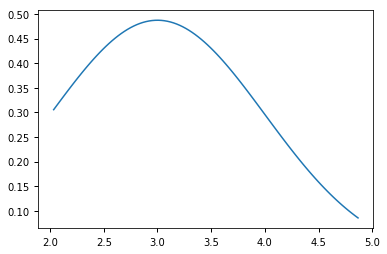

In [15]:
plt.plot(q, d.pdf(q))

In [16]:
import time
import multiprocess as mp
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
labels = [r'$A_{mof}$', r'$FWHM_{mof}$', r'$\beta_{mof}$', r'$\log\,f_{pow}$', r'$n$']

def Nested_Fit_PSF1d(r_rbin, z_rbin, logzerr_rbin, theta_t_pix=theta_t_pix, mu=mu):

    X = r_rbin
    
    I_rbin = Intensity2SB(z_rbin, mu, ZP, pix_scale)
    Y = I_rbin
    log_err = logzerr_rbin * 2.5
    
#     Y = z_rbin
#     log_err = logzerr_rbin
    
    def prior_PSF(u):
        v = u.copy()
        v[0] = u[0] * 2. - 1 + np.log10(Y[0])  # log Amp : log I_0 +/- 1
        v[1] = stats.norm.ppf(u[1], loc=2.2, scale=0.5)  # fwhm : N(2.2, 0.5)
        v[2] = stats.truncnorm.ppf(u[2], a=-1, b=3, loc=5, scale=3.)  # beta : 1-10
        v[3] = u[3] * 2.7 - 3  # frac : 0.001-0.5
        v[4] = u[4] * 3. + 2  # n : 2-5
    
        return v

    def loglike_PSF(v):
        logA, fwhm, beta, logf, n = v
        A_mof, frac = 10**logA, 10**logf
        gamma = fwhm/2./math.sqrt(2**(1./beta)-1)
        moffat_1d = models.Moffat1D(amplitude=A_mof, x_0=0, gamma=gamma, alpha=beta)
        y_mof = moffat_1d(X)
        
        F_mof = moffat1d_Amp2Flux(gamma, beta, Amp=A_mof)
        F_pow = F_mof / (1-frac) * frac
        A_pow = power1d_Flux2Amp(n, theta_t_pix, Flux=F_pow)
        y_pow = trunc_power1d(X, n, theta_t_pix, I_theta0=A_pow)
        
#         ypred = y_mof + y_pow + mu
#         yerr = (2.3*log_err*Y)
        ypred = Intensity2SB(y_mof + y_pow + mu, mu, ZP, pix_scale)
        yerr = log_err
        
        residsq = (ypred - Y)**2 / (yerr**2)  # Fit in Linear
        loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * yerr**2))

        if not np.isfinite(loglike):
            loglike = -1e100

        return loglike

    with mp.Pool(3) as pool:
        pool.size = 3

        dlogz = 1e-3 * (200 - 1) + 0.01

        start = time.time()
        pdsampler = dynesty.DynamicNestedSampler(loglike_PSF, prior_PSF, 5,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=200, nlive_batch=100, maxbatch=4,
                              dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
        end = time.time()

    print("Total time elapsed: %.3gs"%(end-start))
    pdres = pdsampler.results    
    return pdres

In [18]:
labels = [r'$A_{mof}$', r'$FWHM_{mof}$', r'$\beta_{mof}$', r'$\log\,f_{pow}$', r'$n$']

def Nested_Fit_PSF2d(xx, yy, image, mask, log_err, theta_t_pix=theta_t_pix, mu=mu):

    X = np.array([xx,yy])
    Y = image[~mask].ravel()
    log_err = log_err[~mask].ravel()
    
    def prior_PSF(u):
        v = u.copy()
        v[0] = u[0] * 2. - 1 + np.log10(Y.max())  # log Amp : log I_0 +/- 1
        v[1] = stats.norm.ppf(u[1], loc=2.2, scale=0.5)  # fwhm : N(2.2, 0.5)
        v[2] = stats.truncnorm.ppf(u[2], a=-1, b=3, loc=5, scale=3.)  # beta : 1-10
        v[3] = u[3] * 2.7 - 3  # frac : 0.001-0.5
        v[4] = u[4] * 3. + 2  # n : 2-5
    
        return v
    

    def loglike_PSF(v):
        logA, fwhm, beta, logf, n = v
        A_mof, frac = 10**logA, 10**logf
        gamma = fwhm/2./math.sqrt(2**(1./beta)-1)
        moffat_2d = models.Moffat2D(amplitude=A_mof, x_0=50, y_0=50, gamma=gamma, alpha=beta)
        y_mof = moffat_2d(xx,yy)
        
        F_mof = moffat2d_Amp2Flux(gamma, beta, Amp=A_mof)
        F_pow = F_mof / (1-frac) * frac
        A_pow = power2d_Flux2Amp(n, theta_t_pix, Flux=F_pow)
        y_pow = trunc_power2d(xx, yy, n, theta_t_pix, I_theta0=A_pow, cen=(50,50))
        
        ypred = y_mof + y_pow + mu
        yerr = (2.3*log_err*Y)
        residsq = (ypred[~mask].ravel() - Y)**2 / (yerr**2)  # Fit in Linear
        loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * yerr**2))

        if not np.isfinite(loglike):
            loglike = -1e100

        return loglike

    with mp.Pool(3) as pool:
        pool.size = 3

        dlogz = 1e-3 * (200 - 1) + 0.01

        start = time.time()
        pdsampler = dynesty.DynamicNestedSampler(loglike_PSF, prior_PSF, 5,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=200, nlive_batch=100, maxbatch=4,
                              dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
        end = time.time()

    print("Total time elapsed: %.3gs"%(end-start))
    pdres = pdsampler.results    
    return pdres

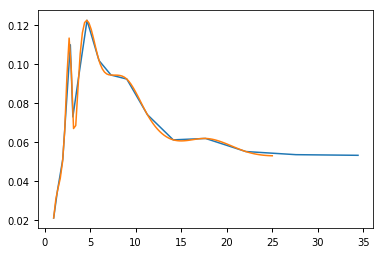

In [19]:
from scipy.interpolate import interp1d
f2 = interp1d(r_rbin ,logzerr_rbin, kind='cubic', bounds_error=False, fill_value=0.06)
rr2 = rr.copy()
rr2[rr2<r_rbin.min()] = r_rbin.min() 

plt.plot(r_rbin ,logzerr_rbin)
plt.plot(np.linspace(1,25,100) , f2(np.linspace(1,25,100)))

In [20]:
res2d = Nested_Fit_PSF2d(xx, yy, image=PSF_JX, mask=mask, log_err=f2(rr2), theta_t_pix=2, mu=mu)

iter: 6552 | batch: 4 | bound: 107 | nc: 8 | ncall: 31762 | eff(%): 20.628 | loglstar: -10435.805 < -10430.072 < -10431.828 | logz: -10450.121 +/-  0.410 | stop:  2.904                              


Total time elapsed: 112s


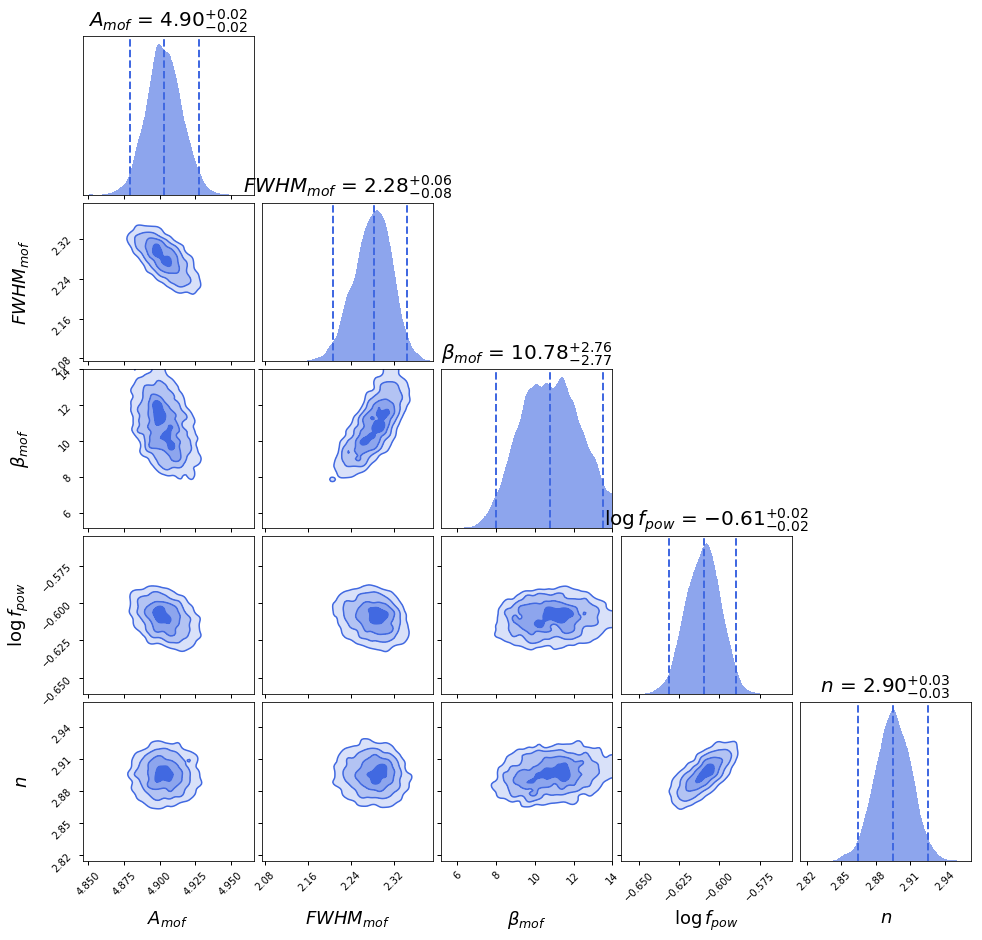

In [21]:
fig, axes = dyplot.cornerplot(res2d, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':20, 'y': 1.02}, labels=labels,
                              label_kwargs={'fontsize':18},
                              fig=plt.subplots(5, 5, figsize=(14, 13)))

Fitting (mean):  [ 4.90316144  2.28040386 10.79740066 -0.60985938  2.89516325]
Fitting (median):  [ 4.90292867  2.28235206 10.78215747 -0.6094183   2.89534357]
Fitting (highest weight):  [ 4.90220011  2.25863593 11.07418387 -0.60557286  2.87417913]


(0.8, 50)

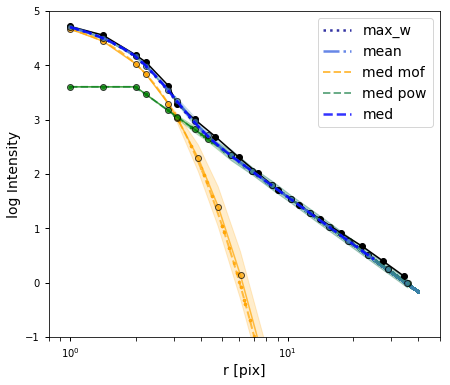

In [143]:
display_nested_fit_2d(res2d, mu=mu, theta_t_pix=2)
plt.plot(r_rbin, np.log10(z_rbin-10), "k-o")

A_mof = 10**4.9
fwhm = 2.28
beta = 10.8
gamma = fwhm/2./np.sqrt(2**(1./beta)-1)
moffat2d = models.Moffat2D(amplitude=A_mof, x_0=50, y_0=50, gamma=gamma, alpha=beta)
m2d = moffat2d(xx, yy) 
_, _, _ = cal_profile_1d(m2d, cen=(50,50), mask=mask,
                         ZP=ZP, sky_mean=0, sky_std=1e-2, pix_scale=pix_scale,
                         xunit="pix", yunit="intensity", color="orange",
                         dr=0.3, scatter=True, core_undersample=True)

n = 2.9
frac = 10**-0.61
F_mof = moffat2d_Amp2Flux(gamma, beta, Amp=A_mof)
F_pow = F_mof / (1-frac) * frac
A_pow = power2d_Flux2Amp(n, theta_t_pix, Flux=F_pow)
p2d = trunc_power2d(xx, yy, n, theta_t_pix, I_theta0=A_pow, cen=(50,50))
_, _, _ = cal_profile_1d(p2d, cen=(50,50), mask=mask,
                         ZP=ZP, sky_mean=0, sky_std=1e-2, pix_scale=pix_scale,
                         xunit="pix", yunit="intensity", color="g",
                         dr=0.3, scatter=True, core_undersample=True)

_, _, _ = cal_profile_1d(p2d+m2d, cen=(50,50), mask=mask,
                         ZP=ZP, sky_mean=0, sky_std=1e-2, pix_scale=pix_scale,
                         xunit="pix", yunit="intensity", color="steelblue",
                         dr=0.3, scatter=True, core_undersample=True)

plt.xlim(0.8,50)

In [140]:
def display_nested_fit_2d(res, mu=mu, theta_t_pix=theta_t_pix, n_bootstrap=200):

    samples = res.samples                                 # samples
    weights = np.exp(res.logwt - res.logz[-1])            # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)     # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)  # resample weighted samples
    pmed = np.median(samples_eq,axis=0)                    # median sample
    pmxw = samples[weights.argmax()]                       # sample contributing most weights
    
    print("Fitting (mean): ", pmean)
    print("Fitting (median): ", pmed)
    print("Fitting (highest weight): ", pmxw)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootstrap)[0]
    
    plt.figure(figsize=(7,6))
    r = np.linspace(1., 25,101)
    
    for (logA_k, fwhm_k, beta_k, logfrac_k, n_k) in samples_eq_bs:
        A_k = 10**logA_k
        frac_k = 10**logfrac_k
        gamma_k = fwhm_k/2./math.sqrt(2**(1./beta_k)-1)   
        C_mof2Dto1D =  1./(beta_k-1) * 2*math.sqrt(np.pi) * gamma_k * Gamma(beta_k) / Gamma(beta_k-1./2) 
        
        moffat_1d = models.Moffat1D(amplitude=A_k, x_0=0, gamma=gamma_k, alpha=beta_k)
        comp1_k = moffat_1d(r) / C_mof2Dto1D
   
        F_mof_k = moffat1d_Amp2Flux(gamma_k, beta_k, Amp=A_k)
        F_pow_k = F_mof_k / (1-frac_k) * frac_k
        A_pow_k = power1d_Flux2Amp(n_k, theta_t_pix, Flux=F_pow_k)
        C_pow2Dto1D = np.pi * theta_t_pix * (n_k-1) / (n_k-2)
        comp2_k = trunc_power1d(r, n_k, theta_t_pix, I_theta0=A_pow_k) / C_pow2Dto1D
        
        comp1_k = moffat1d_normed(r, gamma=gamma_k, alpha=beta_k) * F_mof_k / C_mof2Dto1D
        comp2_k = trunc_power1d_normed(r, n_k, theta_t_pix) * F_pow_k / C_pow2Dto1D
        
        plt.plot(r, np.log10(comp1_k + comp2_k)+0.4,
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([pmxw, pmed, pmean], ["darkblue", "royalblue", "b"],
                                  [":","-.","--"], ["max_w", "mean", "med"]):
            A_fit = 10**fits[0]
            f_fit = 10**fits[3]
            gamma = fits[1]/2./math.sqrt(2**(1./fits[2])-1)
            moffat1d = models.Moffat1D(amplitude=A_fit, x_0=0, gamma=gamma, alpha=fits[2])
            C_mof2Dto1D =  1./(fits[2]-1) * 2*math.sqrt(np.pi) * gamma * Gamma(fits[2]) / Gamma(fits[2]-1./2)
            comp1 = moffat_1d(r)

            F_mof = moffat1d_Amp2Flux(gamma, fits[2], Amp=A_fit)
            F_pow = F_mof / (1-f_fit) * f_fit
            A_pow = power1d_Flux2Amp(fits[4], theta_t_pix, Flux=F_pow)
            C_pow2Dto1D = np.pi * theta_t_pix * (fits[4]-1) / (fits[4]-2)
            comp2 = trunc_power1d(r, fits[4], theta_t_pix, I_theta0=A_pow) 
            
            comp1 = moffat1d_normed(r, gamma=gamma, alpha=fits[2]) * F_mof / C_mof2Dto1D
            comp2 = trunc_power1d_normed(r, fits[4], theta_t_pix) * F_pow / C_pow2Dto1D
            
            y_fit = comp1 + comp2
            plt.plot(r, np.log10(y_fit)+0.4, color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
            if l=="mean":
                plt.plot(r, np.log10(comp1)+0.4,
                         color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=3)
                plt.plot(r, np.log10(comp2)+0.4,
                         color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=3)


#     logA_mof, fwhm, beta, logfrac_k, n_k  = truth["logA"], truth["fwhm"], truth["beta"], 
#                                             truth["logfrac_k"], truth["n_k"]
    
    plt.xlabel("r [pix]", fontsize=14)
    plt.ylabel("log Intensity", fontsize=14)
    plt.xscale('log')
    plt.legend(fontsize=14,loc="best")
    plt.ylim(-1, 5)